<a href="https://colab.research.google.com/github/xiaoshaoyc/CSCI-4962/blob/main/CSCI_4962_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Oct 23 09:58:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Task 0
I used [pytorch](https://pytorch.org/) framework.

I chose [this MasterCard Stock Data](https://www.kaggle.com/datasets/kalilurrahman/mastercard-stock-data-latest-and-updated), and I tried to predict the future price of the stock. For simplicity and practice purposes, I define the problem as:

> Given the highest stock price of $N$ continuous business day, we try to predict the highest stock price on day $N+1$.

[link to dataset](https://raw.githubusercontent.com/kalilurrahman/MasterCardStockData/main/Mastercard_stock_history.csv)

----

We need to use RNN to solve this problem since the order of the input data matters. In our problem, the stock price of day $N+1$ is most related to the stock price of day $N$, and least related to the stock price of day $0$.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split, ConcatDataset
from torch.utils.data import TensorDataset
import torch.optim as optim
from torch import nn
import torch.nn.functional as F

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# download dataset
!curl -o dataset.csv https://raw.githubusercontent.com/kalilurrahman/MasterCardStockData/main/Mastercard_stock_history.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  380k  100  380k    0     0  1470k      0 --:--:-- --:--:-- --:--:-- 1465k


# Exploratory Data Analysis

There is no missing value or mismatched value in the dataset. I noticed that there are some 'gaps' between the date, however, this is because the stock market does not open during the weekend. Another EDA shows that `Open`, `High`, `Low`, and `Close` are highly correlated. We dropped other columns since our task focuses on the highest price of the day. 

In [4]:
raw_dataset = pd.read_csv("dataset.csv", index_col="Date", parse_dates=["Date"]) \
    .drop(["Dividends", "Stock Splits"], axis=1)

print('data sample', raw_dataset.head(), sep='\n', end='\n\n\n')

print('raw_dataset.info()')
raw_dataset.info()
print(end='\n\n')

print('raw_dataset.describe()', raw_dataset.describe(), sep='\n')

data sample
                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


raw_dataset.info()
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3872 entries, 2006-05-25 to 2021-10-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3872 non-null   float64
 1   High    3872 non-null   float64
 2   Low     3872 non-null   float64
 3   Close   3872 non-null   float64
 4   Volume  3872 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 181.5 KB


raw_dataset.describe()
              Open         High          Low        Close        Volume
c

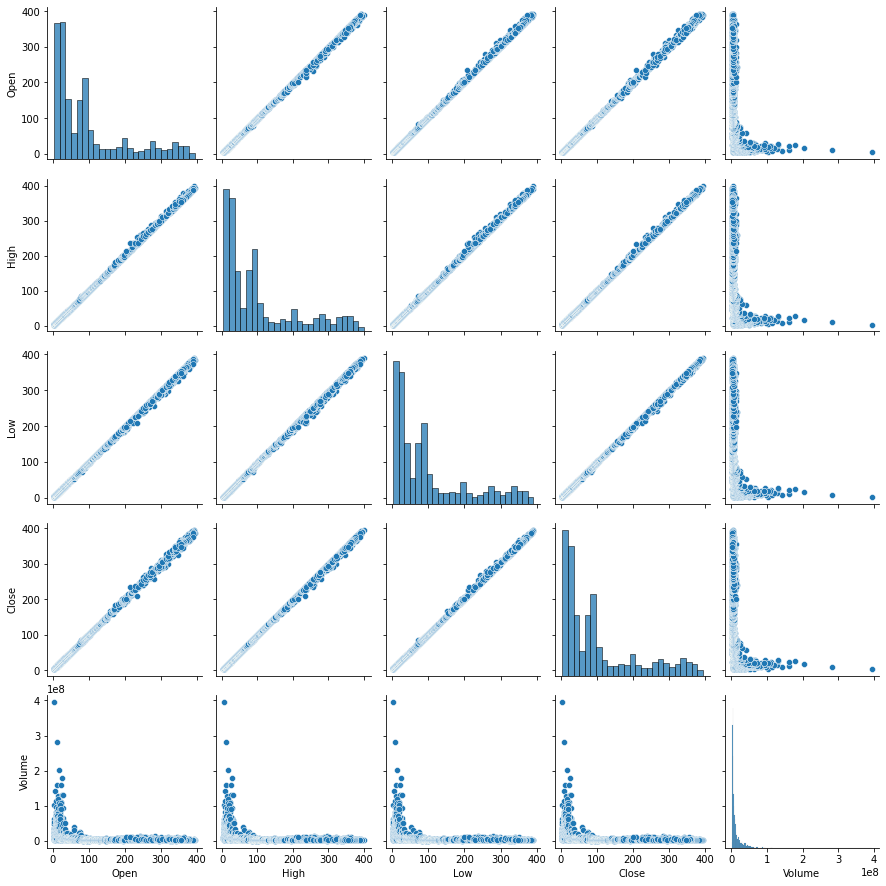

In [5]:
sns.pairplot(data=raw_dataset)

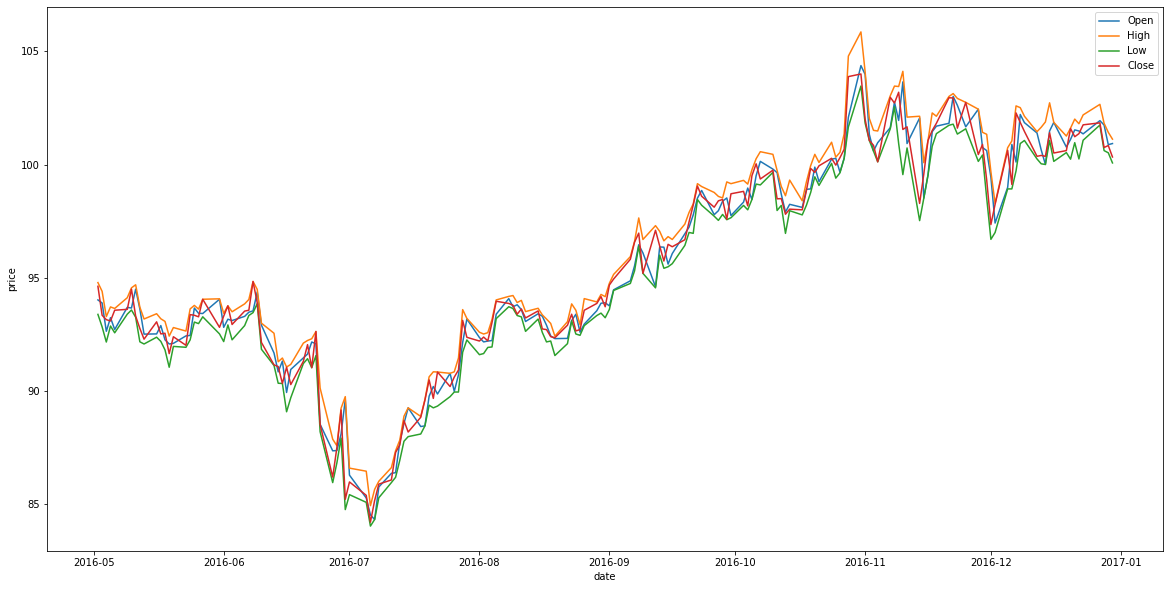

In [15]:
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

plt.rcParams["figure.figsize"] = (20,10)

start_date = '2016-05'
end_date = '2016'

dopen = raw_dataset.loc[start_date:end_date, 'Open']
dhigh = raw_dataset.loc[start_date:end_date, 'High']
dlow = raw_dataset.loc[start_date:end_date, 'Low']
dclose = raw_dataset.loc[start_date:end_date, 'Close']
plt.plot(dopen, label="Open")
plt.plot(dhigh, label="High")
plt.plot(dlow, label="Low")
plt.plot(dclose, label="Close")

plt.xlabel('date')
plt.ylabel('price')

plt.legend()

# Data Pre-processing

In [5]:
# prepare the dataset
class ArrayDataset(Dataset):
  def __init__(self, data, input_len=10, transform=None, target_transform=None):
    self.data = data
    self.input_len = input_len
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.data) - self.input_len - 1

  def __getitem__(self, idx):
    idx = idx
    x = self.data[-idx-1-self.input_len : -idx-1]
    y = self.data[-idx-1]
    return torch.tensor(x, dtype=torch.float32).reshape(-1, 1), \
        torch.tensor([y], dtype=torch.float32)

In [6]:
# train-dev-test partition
full_dataset = ArrayDataset(raw_dataset['High'].values, input_len=30)
def partition_dataset(dataset):
  partition_plan = np.round(np.array([0.7, 0.2, 0.1]) * len(dataset)).astype(np.int32)
  partition_plan[2] = len(dataset) - np.sum(partition_plan[:2])
  trainset, valset, testset = random_split(
      dataset, partition_plan,
      generator=torch.Generator().manual_seed(0)
    )
  return trainset, valset, testset

trainset, valset, testset = partition_dataset(full_dataset)
print(f'len(full_dataset) = {len(full_dataset)}')
print(f'len(trainset) = {len(trainset)}')
print(f'len(valset) = {len(valset)}')
print(f'len(testset) = {len(testset)}')

len(full_dataset) = 3841
len(trainset) = 2689
len(valset) = 768
len(testset) = 384


# Task 1


### Network Implementation
Since we only have one feature, we decided to adopt a lightweight network that consists of one RNN layer, one activation layer, and one fully connected layer. We used `tanh` as our activation function, and `MSELoss()` as our loss function.

In [7]:
# define network
class LstmNetwork(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.lstm = nn.LSTM(input_size=1,hidden_size=300,
                dropout=0, batch_first=True)
    self.fc1 = nn.Linear(300, 1)
    
  def forward(self, x):
    out, _ = self.lstm(x)
    out2 = torch.tanh(out[:, -1, :])
    out3 = self.fc1(out2)
    return out3

class RNNNetwork(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.rnn = nn.RNN(input_size=1,hidden_size=300,
                dropout=0, batch_first=True)
    self.fc1 = nn.Linear(300, 1)
    
  def forward(self, x):
    out, _ = self.rnn(x)
    out2 = torch.tanh(out[:, -1, :])
    out3 = self.fc1(out2)
    return out3

class GRUNetwork(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.gru = nn.GRU(input_size=1,hidden_size=300,
                dropout=0, batch_first=True)
    self.fc1 = nn.Linear(300, 1)
    
  def forward(self, x):
    out, _ = self.gru(x)
    out2 = torch.tanh(out[:, -1, :])
    out3 = self.fc1(out2)
    return out3

### miscellaneous
class LstmNetwork2(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.lstm = nn.LSTM(input_size=1,hidden_size=500,
                dropout=0, batch_first=True)
    self.fc1 = nn.Linear(500, 1)
    
  def forward(self, x):
    out, _ = self.lstm(x)
    out2 = torch.tanh(out[:, -1, :])
    out3 = self.fc1(out2)
    return out3

In [8]:
# use GPU
device = torch.device('cuda:0')

In [17]:
# define some useful functions

@torch.no_grad()
def val(m, loss_fn, valloader):
  loss_list = []
  for x, y in valloader:
    x = x.to(device)
    y = y.to(device)
    y_pred = m(x)
    loss = loss_fn(y_pred, y)
    loss_list.append(loss.item())
  return sum(loss_list) / len(loss_list)

def train(epoch, m, loss_fn, optimizer, trainloader, valloader=None):
  pbar = tqdm(range(epoch))
  loss_list = []
  val_loss_list = []
  val_loss = 0.
  best_model = m.state_dict()
  best_val_loss = 0xFFFFFFFF
  best_epoch = 200
  for i in pbar:
    sub_loss_list = []
    for x, y in trainloader:
      x = x.to(device)
      y = y.to(device)
      y_pred = m(x)

      optimizer.zero_grad()
      loss = loss_fn(y_pred, y)
      loss_num = loss.item()
      sub_loss_list.append(loss_num)
      pbar.set_description(f'val_loss={val_loss:.4} loss={loss_num:.4}') 

      loss.backward()
      optimizer.step()
    
    epoch_loss = sum(sub_loss_list) / len(sub_loss_list)
    loss_list.append(epoch_loss)

    if valloader is not None:
      val_loss = val(m, loss_fn, valloader)
      pbar.set_description(f'val_loss={val_loss:.4} loss={loss_num:.4}') 
      val_loss_list.append(val_loss)
      if (epoch > best_epoch) and (val_loss < best_val_loss):
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = m.state_dict()

  print(f'train finished. Best model at epoch={best_epoch} with val_loss={best_val_loss}')
  m.load_state_dict(best_model)
  return loss_list, val_loss_list

### Hyperparameter tuning

We tuned our network manually. The table contains most combinations of hyperparameters we tried for our network, and the code below also shows some validation results.

Since we tried different input sequence lengths(`input_len`), we have to partition the dataset multiple times. The `partition_dataset` function has a constant seed, resulting in a predictable partitioning. In addition, we engineered the preparation of the dataset in a way that forces it to always return the same sample from the same index.

|  | hidden_size | input_len | optimizer |
|---|---|---|---|
| 1 | 30 | 5 | RMSprop |
| 2 | 30 | 30 | RMSprop |
| 3 | 125 | 5 | RMSprop |
| 4 | 125 | 30 | RMSprop |
| 5 | 300 | 5 | RMSprop |
| 6 | 300 | 8 | RMSprop |
| 7 | 300 | 15 | RMSprop |
| 8 | 300 | 20 | RMSprop |
| 9 | 300 | 30 | RMSprop |
| 10 | 300 | 5 | Adam |
| 11 | 300 | 8 | Adam |
| 12 | 300 | 20 | Adam |
| 13 | 300 | 30 | Adam |
| 14 | 500 | 80 | Adam |
| 15 | 300 | 80 | Adam |
| 16 | 500 | 20 | Adam |

Finally, we decided to use `hidden_size=300`, `input_len=20`, and `optimizer=Adam`.

#### code

  0%|          | 0/500 [00:00<?, ?it/s]

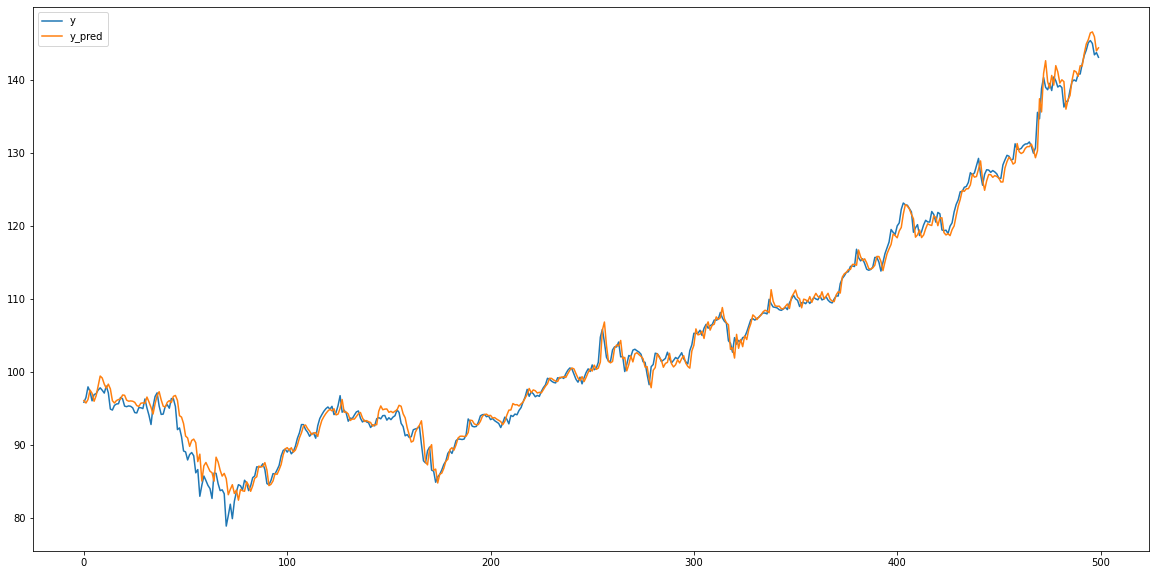

In [12]:
dataset = ArrayDataset(raw_dataset['High'].values, input_len=80)
trainset, valset, testset = partition_dataset(dataset)
model = LstmNetwork2().to(device)
loss_fn = nn.MSELoss()
# optimizer = optim.RMSprop(model.parameters(), \
#       lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
dataloader = DataLoader(trainset, batch_size=len(trainset), shuffle=True)
valloader = DataLoader(valset, batch_size=len(valset), shuffle=False)
loss_list, _ = train(500, model, loss_fn, optimizer, dataloader, valloader)

y_list = []
y_pred_list = []
for i in range(1000, 1500)[::-1]:
  x, y = dataset[i]
  x= x.to(device).reshape(1, -1, 1)
  y_list.append(y.item())
  y_pred = model(x)
  y_pred_list.append(y_pred.item())

plt.plot(y_list, label='y')
plt.plot(y_pred_list, label='y_pred')
plt.legend()

  0%|          | 0/500 [00:00<?, ?it/s]

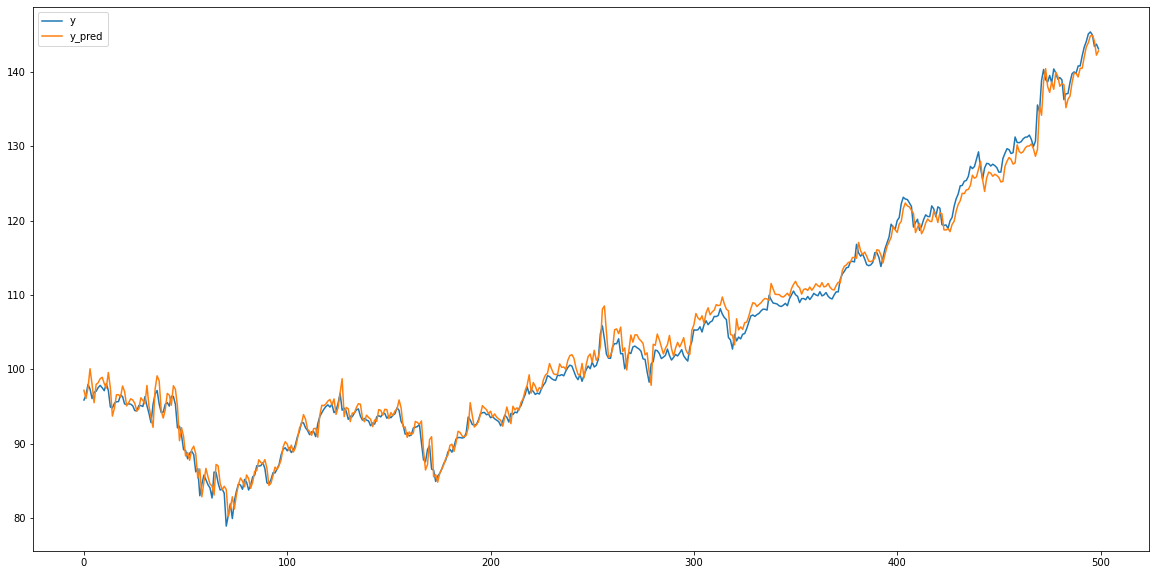

In [21]:
dataset = ArrayDataset(raw_dataset['High'].values, input_len=80)
model = LstmNetwork().to(device)
loss_fn = nn.MSELoss()
# optimizer = optim.RMSprop(model.parameters(), \
#       lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
dataloader = DataLoader(dataset, batch_size=len(dataset)//4, shuffle=True)
loss_list, _ = train(500, model, loss_fn, optimizer, dataloader)

y_list = []
y_pred_list = []
for i in range(1000, 1500)[::-1]:
  x, y = dataset[i]
  x= x.to(device).reshape(1, -1, 1)
  y_list.append(y.item())
  y_pred = model(x)
  y_pred_list.append(y_pred.item())

plt.plot(y_list, label='y')
plt.plot(y_pred_list, label='y_pred')
plt.legend()

  0%|          | 0/500 [00:00<?, ?it/s]

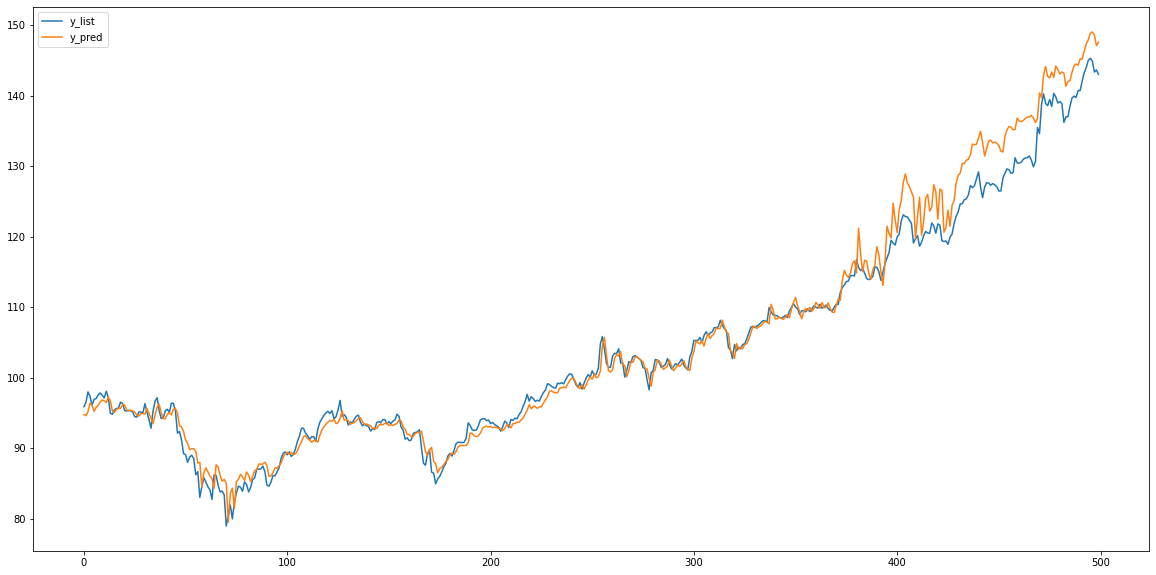

In [14]:
dataset = ArrayDataset(raw_dataset['High'].values, input_len=20)
trainset, valset, testset = partition_dataset(dataset)
model = LstmNetwork2().to(device)
loss_fn = nn.MSELoss()
# optimizer = optim.RMSprop(model.parameters(), \
#       lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
dataloader = DataLoader(dataset, batch_size=len(dataset)//4, shuffle=True)
valloader = DataLoader(valset, batch_size=len(valset), shuffle=False)
loss_list, _ = train(500, model, loss_fn, optimizer, dataloader, valloader)

y_list = []
y_pred_list = []
for i in range(1000, 1500)[::-1]:
  x, y = dataset[i]
  x= x.to(device).reshape(1, -1, 1)
  y_list.append(y.item())
  y_pred = model(x)
  y_pred_list.append(y_pred.item())

plt.plot(y_list, label='y_list')
plt.plot(y_pred_list, label='y_pred')
plt.legend()

### metric
We use the following metric to evaluate the performance of the model.
$$\text{Metric}(pred, truth) = (pred - truth)^2$$

### RNN, LSTM, and GRU

In [18]:
dataset = ArrayDataset(raw_dataset['High'].values, input_len=20)
trainset, valset, testset = partition_dataset(dataset)
loss_fn = nn.MSELoss()

  0%|          | 0/500 [00:00<?, ?it/s]

train finished. Best model at epoch=500 with val_loss=20426.6640625


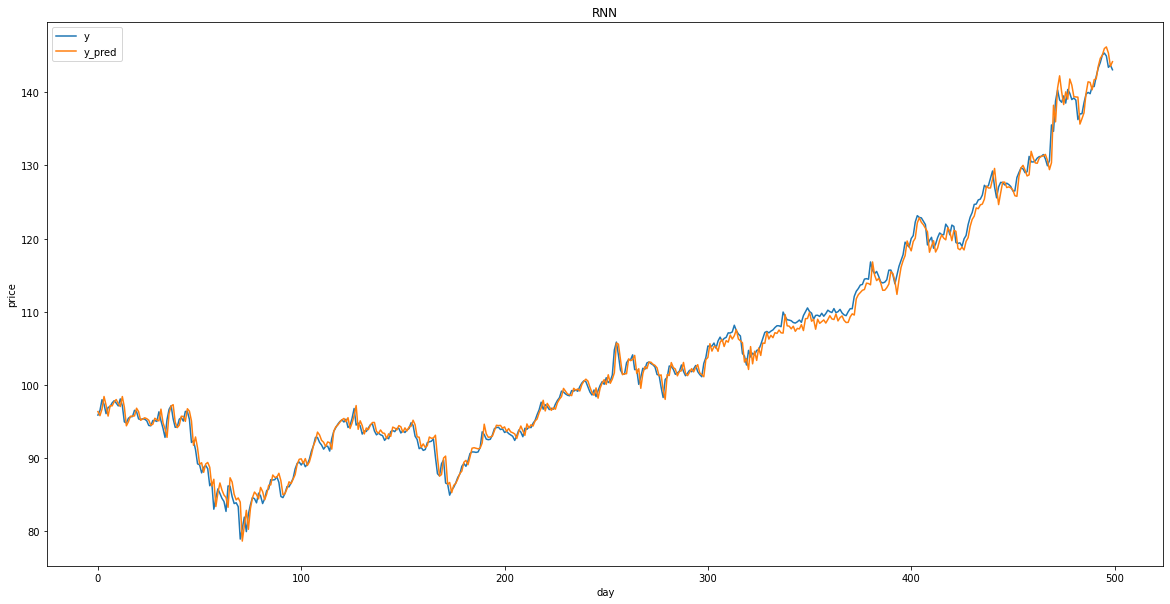

In [19]:
model1 = RNNNetwork().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
valloader = DataLoader(valset, batch_size=len(valset), shuffle=False)
loss_list1, _ = train(500, model1, loss_fn, optimizer, dataloader, valloader)

y_list = []
y_pred_list = []
for i in range(1000, 1500)[::-1]:
  x, y = dataset[i]
  x= x.to(device).reshape(1, -1, 1)
  y_list.append(y.item())
  y_pred = model1(x)
  y_pred_list.append(y_pred.item())

plt.plot(y_list, label='y')
plt.plot(y_pred_list, label='y_pred')
plt.xlabel("day")
plt.ylabel("price")
plt.title("RNN")
plt.legend()

In [ ]:
model2 = LstmNetwork().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.002)
dataloader = DataLoader(trainset, batch_size=len(trainset), shuffle=True)
valloader = DataLoader(valset, batch_size=len(valset), shuffle=False)
loss_list2, _ = train(500, model2, loss_fn, optimizer, dataloader, valloader)

y_list = []
y_pred_list = []
for i in range(1000, 1500)[::-1]:
  x, y = dataset[i]
  x= x.to(device).reshape(1, -1, 1)
  y_list.append(y.item())
  y_pred = model2(x)
  y_pred_list.append(y_pred.item())

plt.plot(y_list, label='y')
plt.plot(y_pred_list, label='y_pred')
plt.xlabel("day")
plt.ylabel("price")
plt.title("LSTM Network")
plt.legend()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

train finished. Best model at epoch=500 with val_loss=20518.396484375


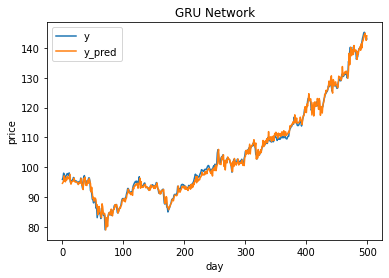

In [13]:
model3 = GRUNetwork().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.002)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
valloader = DataLoader(valset, batch_size=len(valset), shuffle=False)
loss_list3, _ = train(500, model3, loss_fn, optimizer, dataloader, valloader)

y_list = []
y_pred_list = []
for i in range(1000, 1500)[::-1]:
  x, y = dataset[i]
  x= x.to(device).reshape(1, -1, 1)
  y_list.append(y.item())
  y_pred = model3(x)
  y_pred_list.append(y_pred.item())

plt.plot(y_list, label='y')
plt.plot(y_pred_list, label='y_pred')
plt.xlabel("day")
plt.ylabel("price")
plt.title("GRU Network")
plt.legend()

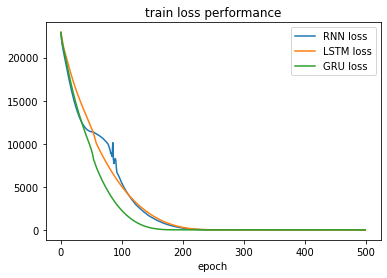

In [14]:
plt.plot(loss_list1, label="RNN loss")
plt.plot(loss_list2, label="LSTM loss")
plt.plot(loss_list3, label="GRU loss")

plt.title("train loss performance")
plt.xlabel("epoch")
plt.legend()

In [30]:
testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)
rnn_test = val(model1, loss_fn, testloader)
lstm_test = val(model2, loss_fn, testloader)
gru_test = val(model3, loss_fn, testloader)
print(f'rnn_test_result\t\t:\t{rnn_test}')
print(f'lstm_test_result\t:\t{lstm_test}')
print(f'gru_test_result\t\t:\t{gru_test}')


rnn_test_result		:	6.911357402801514
lstm_test_result	:	6.845522880554199
gru_test_result		:	15.565995216369629



LSTM and GRU has a data highway design that can transport long time (ancient) data all the way down. So, they are more resisted to forget old memories.

  0%|          | 0/500 [00:00<?, ?it/s]

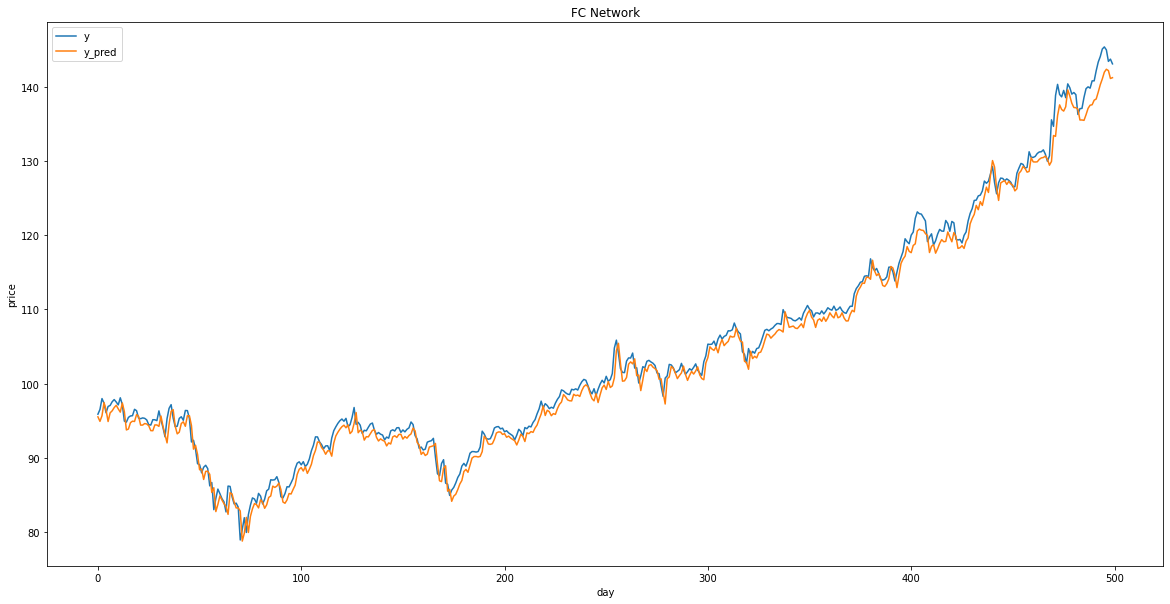

In [29]:
model_test = nn.Sequential(
    nn.Flatten(),
    nn.Linear(20, 300),
    nn.Tanh(),
    nn.Linear(300, 1)
)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
dataloader = DataLoader(trainset, batch_size=len(trainset), shuffle=True)
valloader = DataLoader(valset, batch_size=len(valset), shuffle=False)
loss_list2, _ = train(500, model2, loss_fn, optimizer, dataloader, valloader)

y_list = []
y_pred_list = []
for i in range(1000, 1500)[::-1]:
  x, y = dataset[i]
  x= x.to(device).reshape(1, -1, 1)
  y_list.append(y.item())
  y_pred = model2(x)
  y_pred_list.append(y_pred.item())

plt.plot(y_list, label='y')
plt.plot(y_pred_list, label='y_pred')
plt.xlabel("day")
plt.ylabel("price")
plt.title("FC Network")
plt.legend()